# Code embedding using Keras

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
font = {'weight': 'bold', 'size': 20}
plt.rc('font', **font)

## Load data

In [5]:
dataframe = pd.read_json('../../data/full_data_v2.json')

In [6]:
dataframe.head(2)

,content,data_source,file_name,file_path,is_header,label,source_repo,source_username
0,namespace Acorn128_raw {\nint numRounds = -1;\...,crypto-competitions,acorn128_encrypt.cpp,None,0.0,1,None,None
1,namespace Aeadaes256ocbtaglen128v1_raw {\nint ...,crypto-competitions,aeadaes256ocbtaglen128v1_encrypt.cpp,None,0.0,1,None,None


In [7]:
'{:,}'.format(len(dataframe))

'27,147'

Target value:

In [8]:
dataframe.label.value_counts()

0    26740
1      407
Name: label, dtype: int64

Remove comments:

Grab docs (code submissions) and labels (correct or not):

In [9]:
import re

def remove_comments(string):
    # remove all occurrences streamed comments (/*COMMENT */) from string
    string = re.sub(re.compile(r"/\*.*?\*/",re.DOTALL ) , "" , string) 
    # remove all occurrence single-line comments (//COMMENT\n ) from string
    string = re.sub(re.compile(r"//.*?\n" ) , "" , string)
    return string


def get_docs_and_labels(df):
    _docs = []
    _labels = []
    for index in df.index:
        # Program
        
        code = remove_comments(
            df.at[index, 'content']
        )
        _docs.append(code)
        # Label
        label = int(df.at[index, 'label'])
        _labels.append(label)
    return _docs, _labels

In [10]:
docs, labels = get_docs_and_labels(dataframe)

In [11]:
'{:,}'.format(len(docs))

'27,147'

In [12]:
for item in dataframe.loc[1:1,'content'].iteritems():
    print(item)

(1, 'namespace Aeadaes256ocbtaglen128v1_raw {\nint numRounds = -1;\n\n/* \n// CAESAR OCB v1 reference code. Info: http://www.cs.ucdavis.edu/~rogaway/ocb\n//\n// ** This version is slow and susceptible to side-channel attacks. **\n// ** Do not use for any purpose other than to understand OCB.      **\n//\n// Written by Ted Krovetz (ted@krovetz.net). Last modified 13 May 2014.\n//\n// Phillip Rogaway holds patents relevant to OCB. See the following for\n// his free patent grant: http://www.cs.ucdavis.edu/~rogaway/ocb/grant.htm\n//\n// This is free and unencumbered software released into the public domain.\n//\n// Anyone is free to copy, modify, publish, use, compile, sell, or\n// distribute this software, either in source code form or as a compiled\n// binary, for any purpose, commercial or non-commercial, and by any\n// means.\n//\n// In jurisdictions that recognize copyright laws, the author or authors\n// of this software dedicate any and all copyright interest in the\n// software to 

## Tokenize code and generate sequences

In [13]:
import os
#To ignore the warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.
/Users/arnaudstiegler/miniconda3/envs/emotion_detection/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/arnaudstiegler/miniconda3/envs/emotion_detection/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/arnaudstiegler/miniconda3/envs/emotion_detection/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qi

In [14]:
#We set the size of the vocabulary
NUM_WORDS = 10000

In [15]:
tokenizer = Tokenizer(num_words=NUM_WORDS, 
                     lower=True, 
                     split=' ', 
                     char_level=False)
#We use default filters

In [17]:
#tokenizer.fit_on_texts(docs)
tokenizer.fit_on_texts(dataframe['content'])

In [18]:
# Size of the vocabulary
len(tokenizer.word_index) 

655567

In [19]:
# document_count: an integer count of the total number of documents that were used to fit the Tokenizer.
'Number docs: {:,}'.format(tokenizer.document_count)

'Number docs: 51,335'

In [20]:
len(tokenizer.word_counts)

655567

In [21]:
# word_docs: a dictionary of words and how many documents each appeared in.
tokenizer.word_docs['if']

47634

In [22]:
#sequences = tokenizer.texts_to_sequences(docs)
sequences = tokenizer.texts_to_sequences(dataframe['content'])

Let's look at the length distribution of the sequences to know what max size to choose

In [23]:
len_seqs = [len(s) for s in sequences]
np.mean(len_seqs), np.std(len_seqs), np.max(len_seqs)

(1999.788521751943, 15593.766226924625, 869223)

The mean is at 2000 but the standard deviation is much bigger

In [24]:
MAX_LENGTH = 2000

Dictionary to transform a vector back to the program:

In [25]:
id_to_word = { v: k for k, v in tokenizer.word_index.items() }

In [26]:
id_to_word[1]

'if'

In [27]:
[id_to_word[index] for index in sequences[0]][0:100]

['namespace',
 'raw',
 'int',
 '1',
 'include',
 'string',
 'h',
 'include',
 'encrypt',
 'h',
 'define',
 'maj',
 'x',
 'y',
 'z',
 'x',
 'y',
 'x',
 'z',
 'y',
 'z',
 'define',
 'ch',
 'x',
 'y',
 'z',
 'x',
 'y',
 'x',
 '1',
 'z',
 'unsigned',
 'char',
 'unsigned',
 'char',
 'state',
 'return',
 'state',
 '12',
 'state',
 'maj',
 'state',
 'state',
 '61',
 'state',
 'unsigned',
 'char',
 'unsigned',
 'char',
 'state',
 'unsigned',
 'char',
 'ks',
 'unsigned',
 'char',
 'ca',
 'unsigned',
 'char',
 'cb',
 'unsigned',
 'char',
 'f',
 'ks',
 'state',
 'f',
 'state',
 '0',
 'state',
 '1',
 'maj',
 'state',
 'state',
 '23',
 'state',
 '160',
 'ch',
 'state',
 'state',
 '111',
 'state',
 '66',
 'ca',
 'state',
 '196',
 'cb',
 'ks',
 'return',
 'f',
 'encrypt',
 'one',
 'bit',
 'void',
 'encrypt',
 'unsigned',
 'char',
 'state',
 'unsigned',
 'char',
 'unsigned',
 'char']

Pad documents:

In [28]:
from keras.preprocessing.sequence import pad_sequences
# pad documents
padded_docs = pad_sequences(sequences, maxlen=MAX_LENGTH, padding='post')

In [29]:
padded_docs[0][0:10]

array([ 746, 1057,    7,    8,   22,  112,   26,   22, 1252,   26],
      dtype=int32)

## Defining the model

In [30]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.layers import Embedding

#We add the epsilon to avoid any error in the function

def precision_(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
    
def recall_(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1(y_true, y_pred):
    
    precision = precision_(y_true, y_pred)
    recall = recall_(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def f2(y_true, y_pred):
    
    precision = precision_(y_true, y_pred)
    recall = recall_(y_true, y_pred)
    return 5*((precision*recall)/(4*precision+recall+K.epsilon()))

In [31]:
from tensorflow.keras.optimizers import Adam
# define the model
model = Sequential()
model.add(Embedding(NUM_WORDS, 50, input_length=MAX_LENGTH))
model.add(Flatten())
model.add(Dropout(rate=0.5))
model.add(Dense(1, activation='sigmoid'))
    
model.compile(optimizer=Adam(learning_rate=5e-5), 
                  loss='binary_crossentropy', 
                  metrics=['acc', f1,f2,precision_,recall_])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2000, 50)          500000    
_________________________________________________________________
flatten (Flatten)            (None, 100000)            0         
_________________________________________________________________
dropout (Dropout)            (None, 100000)            0         
_________________________________________________________________
dense (Dense)                (None, 1)                 100001    
Total params: 600,001
Trainable params: 600,001
Non-trainable params: 0
_________________________________________________________________
None


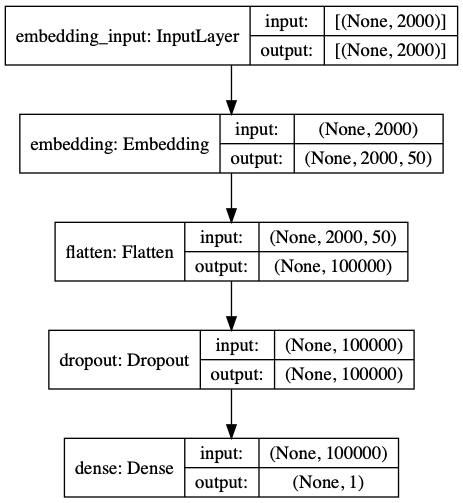

In [32]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [33]:
def plot(history):
  
  # The history object contains results on the training and test
  # sets for each epoch
    acc = history.history['precision_']
    val_acc = history.history['val_precision_']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get the number of epochs
    epochs = range(len(acc))

    _ = plt.figure(figsize=(10,10))
    plt.title('Training and validation precision')
    plt.plot(epochs, acc, color='blue', label='Train')
    plt.plot(epochs, val_acc, color='orange', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend()
    plt.savefig('../code_embedding/plots/training_precision.png')

    _ = plt.figure(figsize=(10,10))
    plt.title('Training and validation loss')
    plt.plot(epochs, loss, color='blue', label='Train')
    plt.plot(epochs, val_loss, color='orange', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('../code_embedding/plots/training_loss.png')

In [34]:
from sklearn.model_selection import train_test_split

indices = np.arange(padded_docs.shape[0])

X_train, X_test, y_train, y_test,train_idx, test_idx = train_test_split(padded_docs, dataframe['label'],indices, 
                                                    test_size=0.2, random_state=0,
                                                    stratify=dataframe['label'])

In [35]:
#Checking the indexing
(X_test[0] == padded_docs[test_idx[0]]).all()

True

In [36]:
# fit the model

history = model.fit(X_train, 
          y_train,
          epochs=30,
          validation_data=(X_test,y_test))

Train on 21717 samples, validate on 5430 samples
Epoch 1/30
21717/21717 [==============================] - 35s 2ms/sample - loss: 0.1192 - acc: 0.9797 - f1: 0.0114 - f2: 0.0116 - precision_: 0.0125 - recall_: 0.0123 - val_loss: 0.0737 - val_acc: 0.9849 - val_f1: 0.0000e+00 - val_f2: 0.0000e+00 - val_precision_: 0.0000e+00 - val_recall_: 0.0000e+00
Epoch 2/30
21717/21717 [==============================] - 34s 2ms/sample - loss: 0.0577 - acc: 0.9853 - f1: 0.0125 - f2: 0.0119 - precision_: 0.0147 - recall_: 0.0115 - val_loss: 0.0586 - val_acc: 0.9849 - val_f1: 0.0118 - val_f2: 0.0118 - val_precision_: 0.0118 - val_recall_: 0.0118
Epoch 3/30
21717/21717 [==============================] - 34s 2ms/sample - loss: 0.0442 - acc: 0.9868 - f1: 0.0546 - f2: 0.0529 - precision_: 0.0604 - recall_: 0.0522 - val_loss: 0.0507 - val_acc: 0.9858 - val_f1: 0.0461 - val_f2: 0.0441 - val_precision_: 0.0529 - val_recall_: 0.0431
Epoch 4/30
21717/21717 [==============================] - 28s 1ms/sample - loss:

21717/21717 [==============================] - 30s 1ms/sample - loss: 0.0018 - acc: 0.9995 - f1: 0.3795 - f2: 0.3787 - precision_: 0.3822 - recall_: 0.3785 - val_loss: 0.0341 - val_acc: 0.9930 - val_f1: 0.2371 - val_f2: 0.2313 - val_precision_: 0.2588 - val_recall_: 0.2294
Epoch 30/30
21717/21717 [==============================] - 30s 1ms/sample - loss: 0.0016 - acc: 0.9997 - f1: 0.3734 - f2: 0.3731 - precision_: 0.3741 - recall_: 0.3730 - val_loss: 0.0344 - val_acc: 0.9930 - val_f1: 0.2549 - val_f2: 0.2497 - val_precision_: 0.2706 - val_recall_: 0.2471


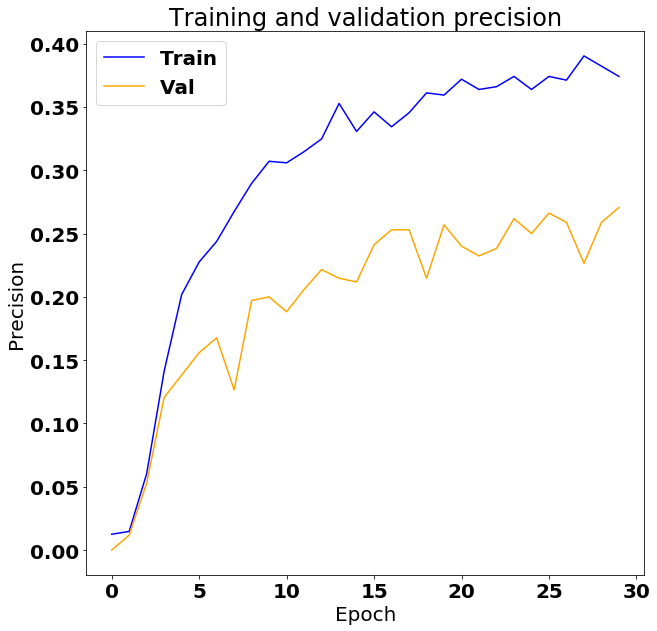

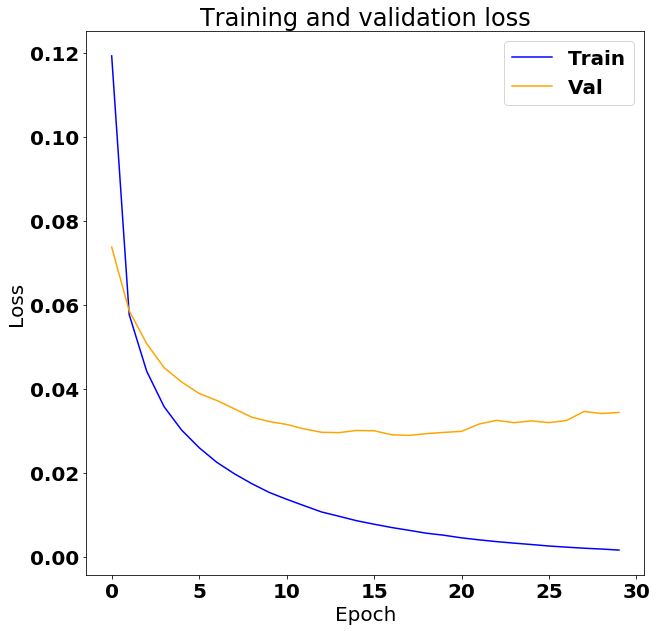

In [37]:
plot(history)

In [38]:
# evaluate the model
word_loss, word_accuracy, word_f1,word_f2, word_precision, word_recall = model.evaluate(X_test, y_test, verbose=1)
print('Accuracy: %f, F1: %f, F2: %f, precision: %f, recall: %f' % (word_accuracy * 100, word_f1 * 100, word_f2 * 100, word_precision*100, word_recall*100))

5430/5430 [==============================] - 1s 174us/sample - loss: 0.0344 - acc: 0.9930 - f1: 0.2529 - f2: 0.2484 - precision_: 0.2706 - recall_: 0.2471
Accuracy: 99.300182, F1: 25.294119, F2: 24.836603, precision: 27.058822, recall: 24.705882


# With class weights

In [39]:
from tensorflow.keras.optimizers import Adam
# define the model
model = Sequential()
model.add(Embedding(NUM_WORDS, 50, input_length=MAX_LENGTH))
model.add(Flatten())
model.add(Dropout(rate=0.5))
model.add(Dense(1, activation='sigmoid'))
    
model.compile(optimizer=Adam(learning_rate=5e-5), 
                  loss='binary_crossentropy', 
                  metrics=['acc', f1,f2,precision_,recall_])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2000, 50)          500000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 100000)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 100001    
Total params: 600,001
Trainable params: 600,001
Non-trainable params: 0
_________________________________________________________________
None


In [40]:
history = model.fit(X_train, 
          y_train,
          epochs=30,
          validation_data=(X_test,y_test),
        class_weight = {0: 1.,
                1: 10.})

Train on 21717 samples, validate on 5430 samples
Epoch 1/30
21717/21717 [==============================] - 31s 1ms/sample - loss: 0.4111 - acc: 0.9767 - f1: 0.0351 - f2: 0.0347 - precision_: 0.0396 - recall_: 0.0361 - val_loss: 0.1312 - val_acc: 0.9851 - val_f1: 0.0294 - val_f2: 0.0287 - val_precision_: 0.0324 - val_recall_: 0.0284
Epoch 2/30
21717/21717 [==============================] - 32s 1ms/sample - loss: 0.2719 - acc: 0.9875 - f1: 0.1392 - f2: 0.1374 - precision_: 0.1524 - recall_: 0.1382 - val_loss: 0.1051 - val_acc: 0.9856 - val_f1: 0.1448 - val_f2: 0.1433 - val_precision_: 0.1534 - val_recall_: 0.1436
Epoch 3/30
21717/21717 [==============================] - 33s 1ms/sample - loss: 0.1923 - acc: 0.9870 - f1: 0.2285 - f2: 0.2325 - precision_: 0.2327 - recall_: 0.2385 - val_loss: 0.0809 - val_acc: 0.9834 - val_f1: 0.1441 - val_f2: 0.1519 - val_precision_: 0.1407 - val_recall_: 0.1618
Epoch 4/30
21717/21717 [==============================] - 27s 1ms/sample - loss: 0.1514 - acc: 0

21717/21717 [==============================] - 56s 3ms/sample - loss: 0.0052 - acc: 0.9995 - f1: 0.3741 - f2: 0.3748 - precision_: 0.3733 - recall_: 0.3756 - val_loss: 0.0293 - val_acc: 0.9934 - val_f1: 0.2488 - val_f2: 0.2485 - val_precision_: 0.2569 - val_recall_: 0.2500
Epoch 30/30
21717/21717 [==============================] - 69s 3ms/sample - loss: 0.0045 - acc: 0.9996 - f1: 0.3775 - f2: 0.3780 - precision_: 0.3770 - recall_: 0.3785 - val_loss: 0.0298 - val_acc: 0.9936 - val_f1: 0.2780 - val_f2: 0.2741 - val_precision_: 0.2912 - val_recall_: 0.2725


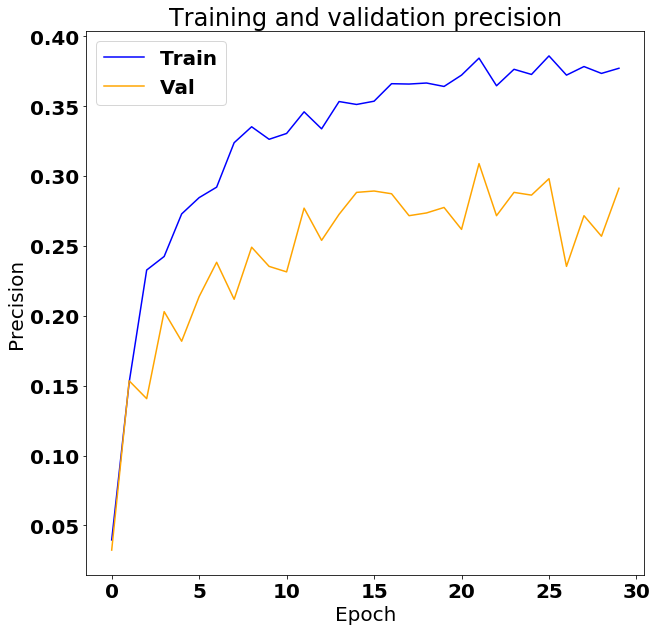

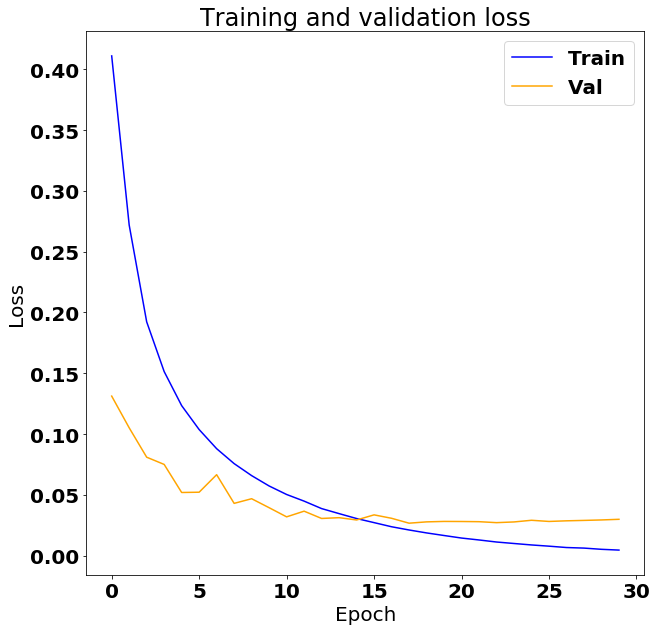

In [41]:
plot(history)

In [42]:
# evaluate the model
word_loss, word_accuracy, word_f1,word_f2, word_precision, word_recall = model.evaluate(X_test, y_test, verbose=1)
print('Accuracy: %f, F1: %f, F2: %f, precision: %f, recall: %f' % (word_accuracy * 100, word_f1 * 100, word_f2 * 100, word_precision*100, word_recall*100))

5430/5430 [==============================] - 2s 394us/sample - loss: 0.0298 - acc: 0.9936 - f1: 0.2743 - f2: 0.2743 - precision_: 0.2824 - recall_: 0.2765
Accuracy: 99.355435, F1: 27.431375, F2: 27.425516, precision: 28.235295, recall: 27.647057


# Adding a dense layer 

In [43]:
from tensorflow.keras.optimizers import Adam
# define the model
model = Sequential()
model.add(Embedding(NUM_WORDS, 50, input_length=MAX_LENGTH))
model.add(Flatten())
model.add(Dense(64))
model.add(Dropout(rate=0.4))
model.add(Dense(1, activation='sigmoid'))
    
model.compile(optimizer=Adam(learning_rate=5e-5), 
                  loss='binary_crossentropy', 
                  metrics=['acc', f1,f2,precision_,recall_])

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 2000, 50)          500000    
_________________________________________________________________
flatten_2 (Flatten)          (None, 100000)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                6400064   
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 6,900,129
Trainable params: 6,900,129
Non-trainable params: 0
_________________________________________________________________
None


In [44]:
history = model.fit(X_train, 
          y_train,
          epochs=20,
          validation_data=(X_test,y_test),
        class_weight = {0: 1.,
                1: 10.})

Train on 21717 samples, validate on 5430 samples
Epoch 1/20
21717/21717 [==============================] - 96s 4ms/sample - loss: 0.2707 - acc: 0.9748 - f1: 0.1743 - f2: 0.1833 - precision_: 0.1735 - recall_: 0.1966 - val_loss: 0.0601 - val_acc: 0.9799 - val_f1: 0.1906 - val_f2: 0.1952 - val_precision_: 0.1961 - val_recall_: 0.2020
Epoch 2/20
21717/21717 [==============================] - 87s 4ms/sample - loss: 0.0866 - acc: 0.9889 - f1: 0.3078 - f2: 0.3168 - precision_: 0.3031 - recall_: 0.3278 - val_loss: 0.0381 - val_acc: 0.9867 - val_f1: 0.2106 - val_f2: 0.2125 - val_precision_: 0.2137 - val_recall_: 0.2157
Epoch 3/20
21717/21717 [==============================] - 87s 4ms/sample - loss: 0.0398 - acc: 0.9958 - f1: 0.3299 - f2: 0.3325 - precision_: 0.3292 - recall_: 0.3357 - val_loss: 0.0322 - val_acc: 0.9899 - val_f1: 0.2573 - val_f2: 0.2587 - val_precision_: 0.2647 - val_recall_: 0.2627
Epoch 4/20
21717/21717 [==============================] - 91s 4ms/sample - loss: 0.0191 - acc: 0

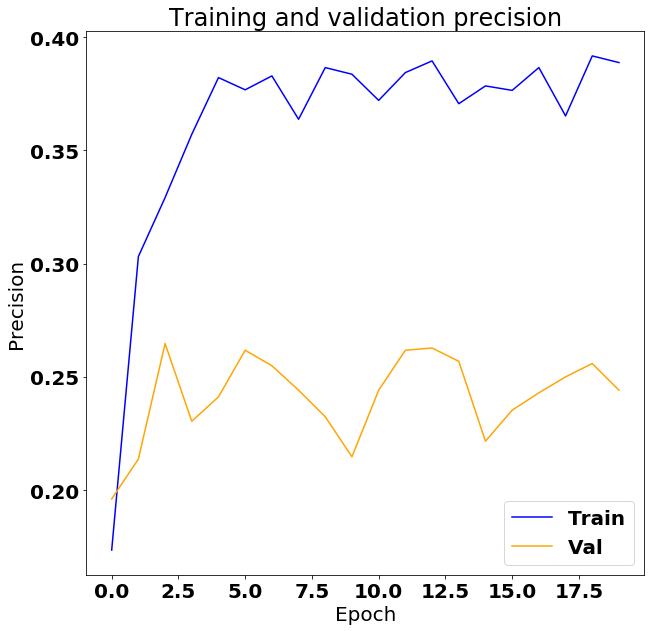

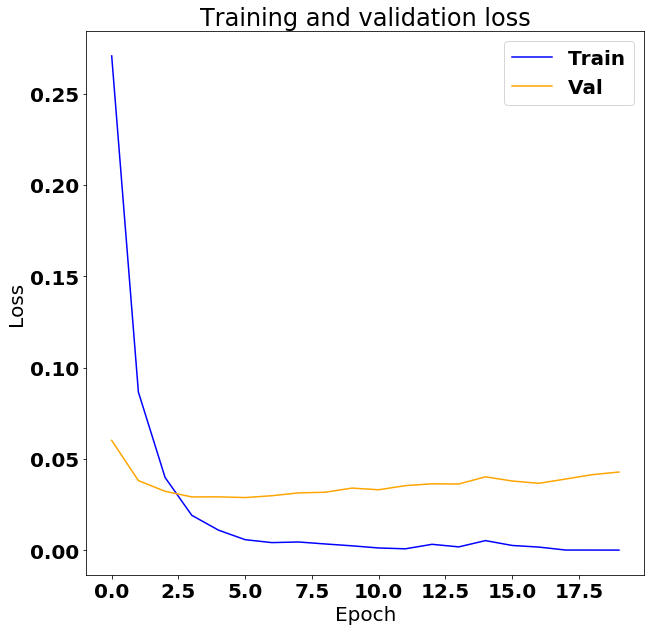

In [45]:
plot(history)

In [46]:
# evaluate the model
word_loss, word_accuracy, word_f1,word_f2, word_precision, word_recall = model.evaluate(X_test, y_test, verbose=1)
print('Accuracy: %f, F1: %f, F2: %f, precision: %f, recall: %f' % (word_accuracy * 100, word_f1 * 100, word_f2 * 100, word_precision*100, word_recall*100))

5430/5430 [==============================] - 2s 413us/sample - loss: 0.0428 - acc: 0.9917 - f1: 0.2292 - f2: 0.2266 - precision_: 0.2422 - recall_: 0.2265
Accuracy: 99.171269, F1: 22.921570, F2: 22.658946, precision: 24.215685, recall: 22.647056
